In [40]:
import torch
from torch import nn,optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import re
import glob
import os
import unicodedata,string
import time
import math,random
import matplotlib.pyplot as plt

In [23]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
1
GeForce 940MX
cuda:0


In [5]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/Scottish.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt']


In [8]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [9]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [10]:
category_lines,all_categories

({'Russian': ['Ababko',
   'Abaev',
   'Abagyan',
   'Abaidulin',
   'Abaidullin',
   'Abaimoff',
   'Abaimov',
   'Abakeliya',
   'Abakovsky',
   'Abakshin',
   'Abakumoff',
   'Abakumov',
   'Abakumtsev',
   'Abakushin',
   'Abalakin',
   'Abalakoff',
   'Abalakov',
   'Abaleshev',
   'Abalihin',
   'Abalikhin',
   'Abalkin',
   'Abalmasoff',
   'Abalmasov',
   'Abaloff',
   'Abalov',
   'Abamelek',
   'Abanin',
   'Abankin',
   'Abarinoff',
   'Abarinov',
   'Abasheev',
   'Abashev',
   'Abashidze',
   'Abashin',
   'Abashkin',
   'Abasov',
   'Abatsiev',
   'Abaturoff',
   'Abaturov',
   'Abaza',
   'Abaziev',
   'Abbakumov',
   'Abbakumovsky',
   'Abbasov',
   'AbdankKossovsky',
   'Abdeev',
   'Abdildin',
   'Abdrahimoff',
   'Abdrahimov',
   'Abdrahmanoff',
   'Abdrahmanov',
   'Abdrakhimoff',
   'Abdrakhimov',
   'Abdrakhmanoff',
   'Abdrakhmanov',
   'Abdrashitoff',
   'Abdrashitov',
   'Abdrazakoff',
   'Abdrazakov',
   'Abdulaev',
   'Abdulatipoff',
   'Abdulatipov',
   'Abd

In [11]:
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [12]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [21]:
class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x, hidden):
        combined = torch.cat((x,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        ouput = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
        

In [22]:
hidden_size = 128
rnn = RNN(n_letters, hidden_size, n_categories)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
rnn.to(device)

RNN(
  (i2h): Linear(in_features=75, out_features=18, bias=True)
  (i2o): Linear(in_features=75, out_features=128, bias=True)
  (softmax): Softmax(dim=1)
)

In [28]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [29]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Kruse
category = English / line = Sharp
category = Dutch / line = Rijnders
category = Russian / line = Neverkovets
category = Japanese / line = Arakida
category = Scottish / line = Boyle
category = Irish / line = John
category = Japanese / line = Fukayama
category = English / line = Wilson
category = German / line = Schmid


In [37]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        tensor = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = rnn(tensor, hidden)
    
    category_tensor = category_tensor.to(device)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [31]:
def getItem(output):
    _, top = output.topk(1)
    top = top[0].item()
    return all_categories[top], top

In [39]:
start = time.time()
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
#     category_tensor = category_tensor.to(device)
#     line_tensor = line_tensor.to(device)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = getItem(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.4651 Maloof / Arabic ✓
10000 10% (0m 20s) 3.1625 Sleiman / Irish ✗ (Arabic)
15000 15% (0m 30s) 3.1365 Bach / Irish ✗ (Vietnamese)
20000 20% (0m 40s) 3.2240 Gagnon / Scottish ✗ (French)
25000 25% (0m 49s) 2.3755 Nakae / Arabic ✗ (Japanese)
30000 30% (0m 59s) 1.0125 Rietveld / Dutch ✓
35000 35% (1m 9s) 0.4357 Jang / Korean ✓
40000 40% (1m 19s) 2.4520 Beringer / German ✗ (French)
45000 45% (1m 29s) 0.6224 Kowalski / Polish ✓
50000 50% (1m 39s) 4.4137 Ogterop / Portuguese ✗ (Dutch)
55000 55% (1m 48s) 0.8756 Youj / Korean ✓
60000 60% (1m 58s) 1.2835 Maradona / Spanish ✓
65000 65% (2m 8s) 2.4003 Michel / Czech ✗ (French)
70000 70% (2m 18s) 0.8787 Romagna / Italian ✓
75000 75% (2m 28s) 0.1294 Taloverov / Russian ✓
80000 80% (2m 37s) 0.3657 Truong / Vietnamese ✓
85000 85% (2m 47s) 0.5421 O'Ryan / Irish ✓
90000 90% (2m 58s) 0.5131 Milano / Italian ✓
95000 95% (3m 8s) 0.8323 Rosario / Portuguese ✓
100000 100% (3m 19s) 0.0165 Georgeakopoulos / Greek ✓


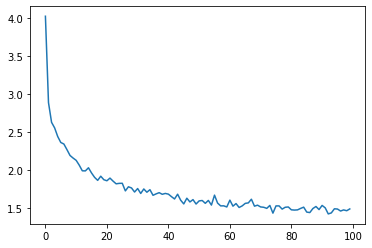

In [41]:
plt.plot(all_losses)

In [47]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        tensor = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = rnn(tensor, hidden)

    return output

In [48]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [49]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(12.10) Russian
(10.28) Czech
(8.80) English

> Jackson
(8.18) Russian
(8.00) Scottish
(7.57) English

> Satoshi
(7.61) Japanese
(7.33) Italian
(5.50) Polish


In [50]:
predict('Hazaki')


> Hazaki
(13.09) Japanese
(10.08) Polish
(8.03) Russian


In [51]:
torch.save(rnn,"word-lang.pt")